# Introduction

[Dataset](https://archive-beta.ics.uci.edu/dataset/296/diabetes+130+us+hospitals+for+years+1999+2008) UCI "Diabetes 130-US hospitals for years 1999-2008" [1]

The purpose of this project is to develop a prediction model for <30-day readmissions of diabetic patients. These readmissions can significantly impact Medicare billing, potentially leading to financial penalties for hospitals with high readmission rates. By identifying the key features used by the model to make its classifications, hospitals can develop informed treatment plans to reduce the likelihood of readmissions. Additionally, the model can be used in real-time to predict the probability of a patient"s readmission, providing healthcare professionals with valuable insights for optimizing patient care.


[1] Clore,John, Cios,Krzysztof, DeShazo,Jon & Strack,Beata. (2014). Diabetes 130-US hospitals for years 1999-2008. UCI Machine Learning Repository. https://doi.org/10.24432/C5230J.

In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time

pd.options.mode.chained_assignment = None # Default = "warn"

seed = 42

start_time = time.time()

In [2]:
plt.style.use("ggplot")

my_style = {
    "axes.prop_cycle": plt.cycler(color=["#015bd3", "#fd5305", "#ffd2ea"]),
    "text.color": "#191919",
    "text.color": "#191919",
    "xtick.color": "#191919",
    "ytick.color": "#191919",
    "axes.labelcolor": "#191919",
    "legend.edgecolor": "white",
    "axes.facecolor": "#ebecf0",
}

# Set the new style for Matplotlib
plt.style.use(my_style)

# Data Processing

In [3]:
df_raw = pd.read_csv("dataset_diabetes/diabetic_data.csv").replace("?", np.nan)
df_raw.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

## Denoise

### Remove columns composed of >30% nan values

Before dropping nan values, I will drop the columns with a signifficant number of nan values.  This will increase the total number of data points after dropping.

In [5]:
df_raw.weight.isna().value_counts(normalize=True)

True     0.968585
False    0.031415
Name: weight, dtype: float64

In [6]:
df = df_raw.copy()

col_to_drop = list(df_raw.columns[df_raw.isna().sum() > len(df_raw) * 0.3])
col_to_drop.remove("medical_specialty") # Proved to be an important feature
list(col_to_drop)

['weight', 'payer_code']

### Remove Unused Medications

In [7]:
unused_meds = ["examide", "citoglipton", "metformin-rosiglitazone"] # Medications which had only values of None
df = df.drop(columns=col_to_drop + unused_meds + ["encounter_id", "patient_nbr"]).dropna()

df.shape

(49735, 43)

### Remove patients who died or were transferred to hospice

These patients will not be readmitted and a model is not needed to determine that.

In [8]:
df = df[~(df.discharge_disposition_id.isin([11, 13, 14, 19, 20, 21, 26]))]

In [9]:
# Create ID mapping dfs
mappings_raw = pd.read_csv("dataset_diabetes/IDs_mapping.csv", header=None)

admin_type_map = mappings_raw.iloc[0:9, :]
discharge_type_map = mappings_raw.iloc[10:41, :]
admin_source_map = mappings_raw.iloc[42:, :]

dfs = [admin_type_map, discharge_type_map, admin_source_map]

for _df in dfs:
    _df.columns = _df.iloc[0]
    _df.drop(_df.index[0], inplace=True)
    _df.reset_index(drop=True, inplace=True)
    _df.set_index(_df.columns[0], inplace=True)
    _df.loc[9] = ["Other"]

admin_type_map

,description
admission_type_id,
1,Emergency
2,Urgent
3,Elective
4,Newborn
5,Not Available
6,NaN
7,Trauma Center
8,Not Mapped
9,Other


In [10]:
int_cats = [] # Store the names of these integer categorical columns for later use

for _df in dfs:
    # Get the mapping id values where the description is equivalent to other
    nan_map = _df[_df.description.isin(["Not Mapped", "Not Available", " Not Available", "Unknown/Invalid", np.nan])]
    col_name = _df.index.name
    int_cats.append(col_name)

    nan_id = nan_map.index.values.astype(int)
    
    df[col_name] = df[col_name].replace(nan_id, 9)

df.admission_type_id.value_counts()

1    19286
2    12068
3    11637
9     5665
4        2
Name: admission_type_id, dtype: int64

## Feature Engineering

### Create ADM_MERGED feature
This combines the 

In [11]:
df["ADM_MERGED"] = df.admission_type_id.astype(str) + "_" + df.medical_specialty

### Group Infrequent Categories

In [12]:
threshold = 0.005 # 0.5%

for col in ["discharge_disposition_id", "admission_source_id", "medical_specialty", "ADM_MERGED"]:
    infrequent_vals = df[col].value_counts()[df[col].value_counts() < threshold * len(df)].index
    repl = 9 if df[col].dtype == int else "other"
    df[col] = df[col].replace(infrequent_vals, repl)

### Binary Features

In [13]:
df = df[~(df.gender == "Unknown/Invalid")]
df.rename({"gender":"sex"}, axis=1, inplace=True)

df.sex = df.sex.apply(lambda x: 0 if x == "Female" else 1)
df.sex.value_counts()

0    26350
1    22307
Name: sex, dtype: int64

In [14]:
df.diabetesMed = df.diabetesMed.apply(lambda x: 0 if x == "No" else 1)
df.change = df.change.apply(lambda x: 0 if x == "No" else 1)

### Age

In [15]:
# make age a continuous variable
df.age = df.age.apply(lambda x: int(np.array(x[1:-1].split("-")).astype(int).mean()))

In [16]:
def convert_age_to_group(age):
    if age < 18:
        return "minor"
    elif age < 65:
        return "adult"
    else:
        return "elderly"

df["age_group"] = df.age.apply(convert_age_to_group)

df.age_group.value_counts(normalize=True)

elderly    0.659083
adult      0.333991
minor      0.006926
Name: age_group, dtype: float64

### Diagnoses

https://www.cms.gov/Medicare/Coding/ICD9ProviderDiagnosticCodes/codes

In [17]:
def get_ICD9_category(value):
        try:
            num = int(float(value))
            if (num >=390 and num <=459 ) or num == 785:
                category = "circulatory"
            elif (num >= 460 and num <= 519) or num == 786:
                category = "respiratory"
            elif (num >= 520 and num <= 579) or num == 787:
                category = "digestive"
            elif num==250:
                category = "diabetes"
            elif num >= 800 and num <= 999:
                category = "injury"
            elif num >= 710 and num <= 739:
                category = "musculoskeletal"
            elif (num >= 580 and num <= 629) or num == 788:
                category = "genitourinary"
            elif num >= 140 and num <= 239:
                category = "neoplasms"
            else:
                category = "other"
        except ValueError:
            category = "other"
        
        return category

In [18]:
# apply the ICD9 categorization function if it has not already been done

if not df.diag_1.isin(["other"]).any():
    for num in range(1,4):
        col_name = f"diag_{num}"
        df[col_name] = df[col_name].apply(get_ICD9_category)

        print(col_name)
        print(df[col_name].value_counts(normalize=True), "\n")



diag_1
circulatory        0.306595
other              0.181146
respiratory        0.131841
digestive          0.088518
diabetes           0.082290
injury             0.067945
musculoskeletal    0.061820
genitourinary      0.045790
neoplasms          0.034055
Name: diag_1, dtype: float64 

diag_2
circulatory        0.326531
other              0.260374
diabetes           0.137226
respiratory        0.098444
genitourinary      0.068685
digestive          0.040590
neoplasms          0.024560
injury             0.024149
musculoskeletal    0.019442
Name: diag_2, dtype: float64 

diag_3
circulatory        0.305506
other              0.288982
diabetes           0.184228
respiratory        0.068397
genitourinary      0.057977
digestive          0.038227
musculoskeletal    0.021148
injury             0.018641
neoplasms          0.016894
Name: diag_3, dtype: float64 



In [19]:
drugs = df.iloc[:, 19:39].copy()

drugs_to_drop = drugs.columns[drugs.nunique() != 4]

df.drop(columns=drugs_to_drop, inplace=True)

In [20]:
num_changes = drugs.copy()
for col in num_changes:
    num_changes[col] = num_changes[col].apply(lambda x: 0 if x in ["No", "Steady"] else 1)

df["num_med_changes"] = num_changes.sum(axis=1)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48657 entries, 9 to 101764
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      48657 non-null  object
 1   sex                       48657 non-null  int64 
 2   age                       48657 non-null  int64 
 3   admission_type_id         48657 non-null  int64 
 4   discharge_disposition_id  48657 non-null  int64 
 5   admission_source_id       48657 non-null  int64 
 6   time_in_hospital          48657 non-null  int64 
 7   medical_specialty         48657 non-null  object
 8   num_lab_procedures        48657 non-null  int64 
 9   num_procedures            48657 non-null  int64 
 10  num_medications           48657 non-null  int64 
 11  number_outpatient         48657 non-null  int64 
 12  number_emergency          48657 non-null  int64 
 13  number_inpatient          48657 non-null  int64 
 14  diag_1               

## Adressing Class Imbalance via Under Sampling

48657


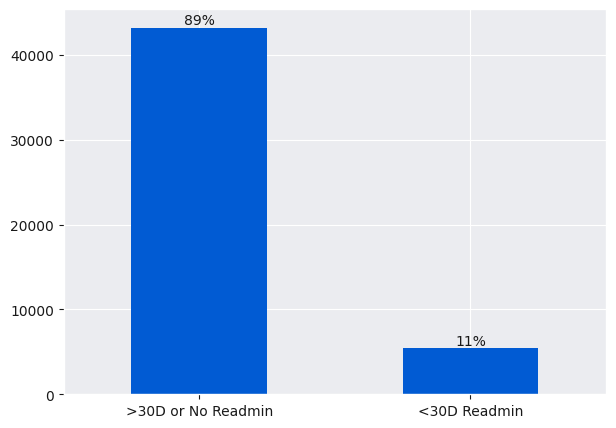

In [22]:
y = df.readmitted
y = y.apply(lambda x: 1 if x == "<30" else 0)

print(len(y))
fig, ax = plt.subplots(figsize=(7, 5))
to_plot = y.value_counts()
bars = to_plot.plot(kind="bar", ax=ax)
for i, v in enumerate(to_plot):
    ax.annotate(str(round(v / len(y) * 100)) + "%", xy=(i, v), ha="center", va="bottom")

ax.set_xticklabels([">30D or No Readmin", "<30D Readmin"], rotation=0)

fig.savefig("Presentation/Images/48657_before_undersamp.png", dpi=300)

10816


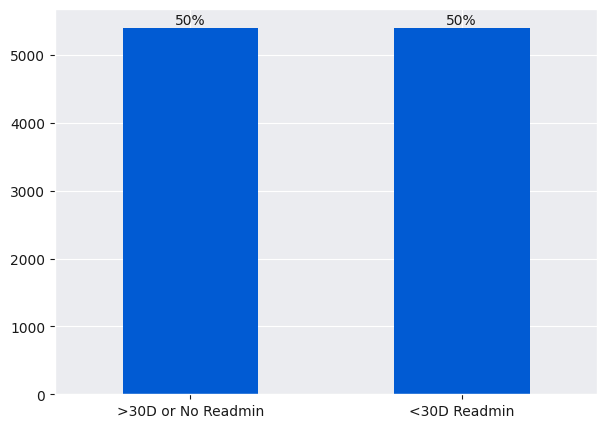

In [23]:
from imblearn.under_sampling import RandomUnderSampler

X = df.drop(columns=["readmitted"])

X, y = RandomUnderSampler(random_state=seed, sampling_strategy=1.0).fit_resample(X, y)

print(len(y))

fig, ax = plt.subplots(figsize=(7, 5))
to_plot = y.value_counts()
bars = to_plot.plot(kind="bar", ax=ax)
for i, v in enumerate(to_plot):
    ax.annotate(str(round(v / len(y) * 100)) + "%", xy=(i, v), ha="center", va="bottom")

ax.set_xticklabels([">30D or No Readmin", "<30D Readmin"], rotation=0)
fig.savefig("Presentation/Images/10816_after_undersamp.png", dpi=300)

In [24]:
cat_cols = X.select_dtypes(include=object).columns.to_list() + int_cats
cont_cols = X.drop(columns=cat_cols).columns.tolist()

for column in cat_cols:
    X.loc[:, column] = X[column].astype(str)

dummies = pd.get_dummies(X[cat_cols])
X.drop(columns=cat_cols, inplace=True)

X = X.join(dummies)

In [25]:
X.groupby("discharge_disposition_id_6").mean()

,sex,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_7,discharge_disposition_id_9,admission_source_id_1,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_9
discharge_disposition_id_6,,,,,,,,,,,,,,,,,,,,,
0,0.452718,65.422829,4.468861,43.194543,1.418246,15.885441,0.249531,0.305874,0.899396,7.276921,...,0.009477,0.02187,0.006561,0.046136,0.337534,0.023537,0.010102,0.030306,0.522912,0.075609
1,0.438221,69.555189,5.603789,42.439868,1.537891,18.794893,0.441516,0.303954,1.063427,7.919275,...,0.000000,0.00000,0.000000,0.000000,0.372323,0.036244,0.006590,0.005766,0.416804,0.162273


In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=seed, stratify=y)

scaler = MinMaxScaler()

X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])
X_test[cont_cols] = scaler.transform(X_test[cont_cols])

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8652, 180), (8652,), (2164, 180), (2164,))

In [27]:
# Import necessary libraries for model evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define a function to print classification metrics and confusion matrix
def eval_model(model):
    for label, y_true, _X in (("Train", y_train, X_train), ("Test", y_test, X_test)):
        y_pred = model.predict(_X)

        fig, axes = plt.subplots(ncols=2, figsize=(10,4))
        
        # Display the classification report, which includes precision, recall, f1-score, and support
        metrics = classification_report(y_true, y_pred)
        ax=axes[1]
        ax.axis("off")
        ax.text(0.5, 0.25, metrics, size=12, ha="center", transform=ax.transAxes)

        ax = axes[0]
        # Create the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Create confusion matrix plot, which shows the counts of true positives, false positives, true negatives, and false negatives
        sns.heatmap(cm, annot=True, fmt="d", cmap="plasma", ax=ax)
        ax.set_ylabel("True label")
        ax.set_xlabel("Predicted label")

        fig.tight_layout()

In [54]:
X.join(y).groupby("readmitted").mean()

,sex,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_9,admission_source_id_1,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_9
readmitted,,,,,,,,,,,,,,,,,,,,,
0,0.448780,65.392012,4.355769,42.700444,1.463572,15.742049,0.240385,0.196376,0.549556,7.168639,...,0.015348,0.108173,0.004993,0.038646,0.349482,0.024778,0.008691,0.030325,0.500925,0.085799
1,0.453402,66.381287,4.836723,43.519231,1.399778,16.681953,0.301775,0.414941,1.286058,7.529401,...,0.023484,0.116309,0.006657,0.043269,0.333395,0.025148,0.010725,0.024778,0.521080,0.084874


# Models

In [28]:
# Import necessary libraries for computing class weights
from sklearn.utils import compute_class_weight

# Compute class weights for the training data
class_weights = [0.95, 1.0]
class_weights_dict = dict(enumerate(class_weights))


## Random Forest

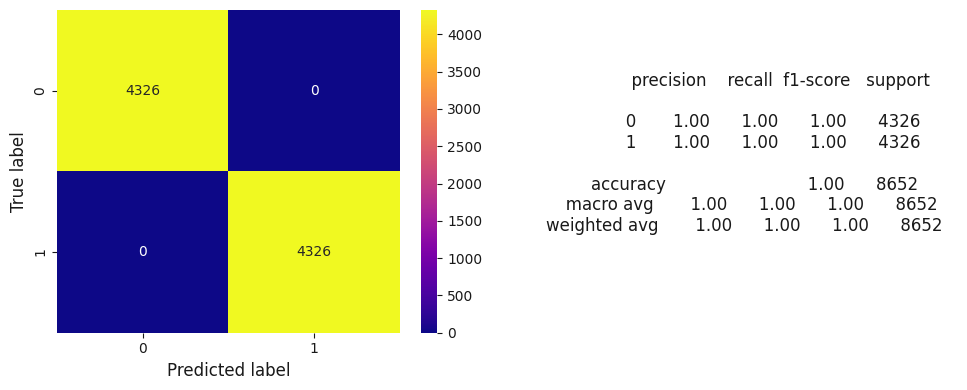

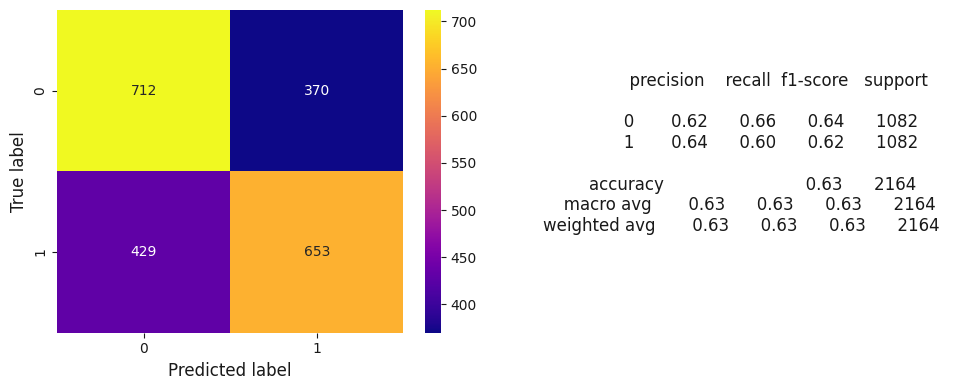

In [29]:
from sklearn.ensemble import RandomForestClassifier

rand_forest = RandomForestClassifier(random_state=seed)

rand_forest.fit(X_train, y_train)

eval_model(rand_forest)

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn import clone

rand_forest_gscv = clone(rand_forest)


# param_grid = {
#     "n_estimators": [200, 500, 750],
#     "max_depth": [None, 5, 7],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
#     "max_features": ["sqrt", "log2"],
#     "bootstrap": [True, False],
#     "class_weight" : ["balanced", class_weights_dict]
# }


# grid_search = GridSearchCV(rand_forest_gscv, param_grid, scoring="roc_auc", n_jobs=-1)
# grid_search.fit(X_train, y_train)

# grid_search.best_params_

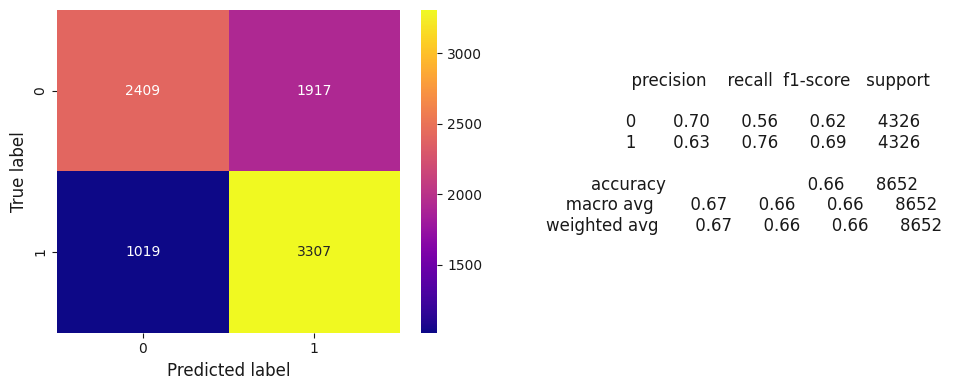

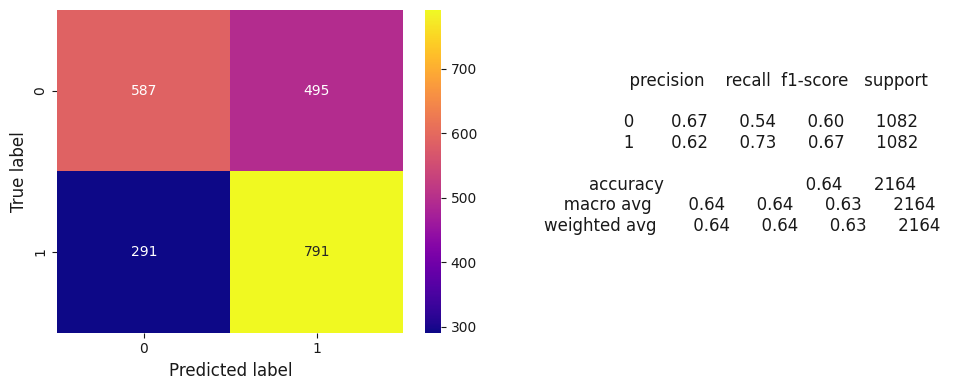

In [31]:
params = {
    "bootstrap": True,
    "class_weight": {0: 0.9, 1: 1.0},
    "max_depth": 7,
    "max_features": "sqrt",
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "n_estimators": 750
}

rand_forest_gscv.set_params(**params)
rand_forest_gscv.fit(X_train, y_train)
eval_model(rand_forest_gscv)

## LightGBM

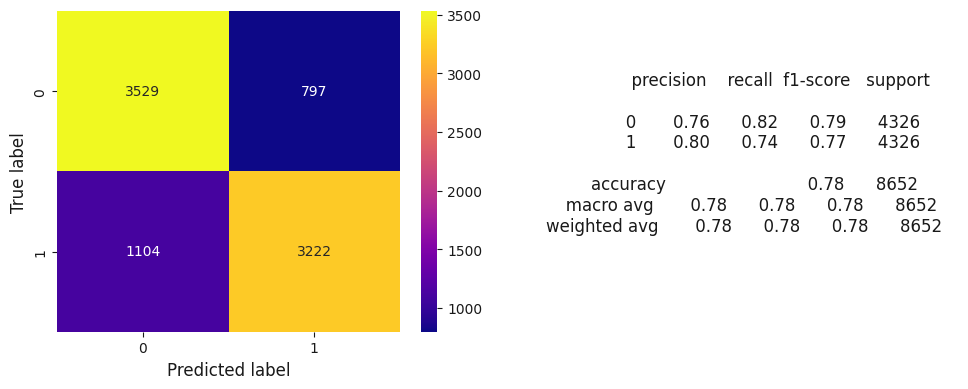

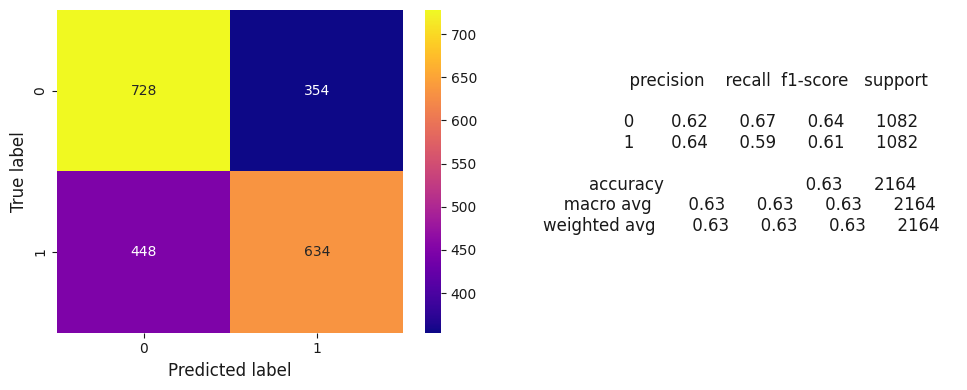

In [32]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=seed)

lgbm.fit(X_train, y_train)

eval_model(lgbm)

In [33]:
lgbm_gscv = clone(lgbm)

# param_grid = {
#     "learning_rate": [0.01, 0.1, 0.05],
#     "n_estimators": [100, 500],
#     "max_depth": [3, 5, None],
#     "num_leaves": [5, 10, 20],
#     "min_child_samples": [10, 20, 30],
#     "reg_lambda": [0.0, 0.1, 0.5],
#     "colsample_bytree": [0.5, 0.7, 0.9],
#     "subsample": [0.5, 0.7, 0.9],
#     "class_weight" : ["balanced", class_weights_dict]
# }

# grid_search = GridSearchCV(lgbm_gscv, param_grid, scoring="roc_auc", n_jobs=-1)
# grid_search.fit(X_train, y_train)

# grid_search.best_params_

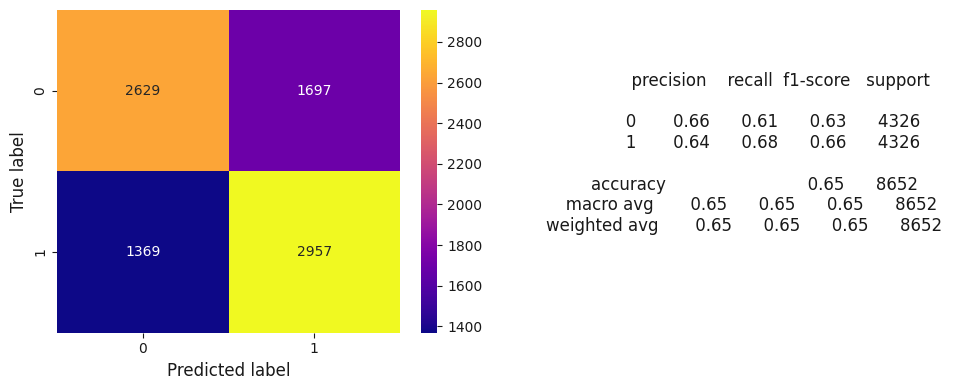

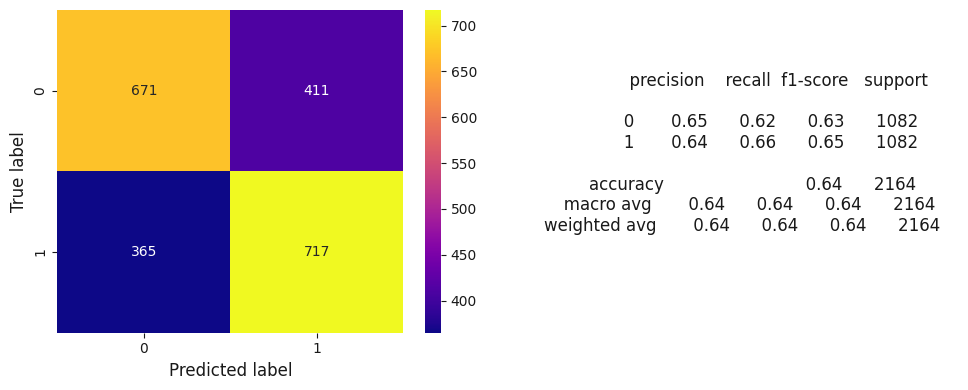

In [34]:
params = {
    "class_weight": {0: 0.9, 1: 1.0},
    "colsample_bytree": 0.5,
    "learning_rate": 0.05,
    "max_depth": None,
    "min_child_samples": 30,
    "n_estimators": 100,
    "num_leaves": 10,
    "reg_lambda": 0.0,
    "subsample": 0.5
}

# params = grid_search.best_params_

lgbm_gscv.set_params(**params)
lgbm_gscv.fit(X_train, y_train)

eval_model(lgbm_gscv)

## CatBoost

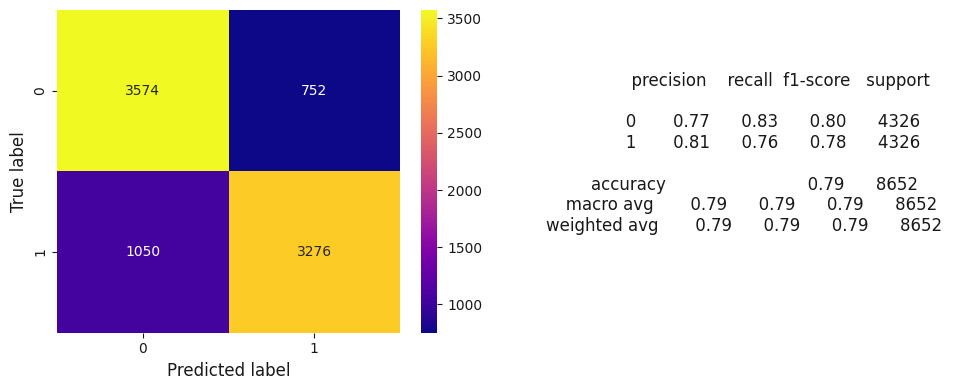

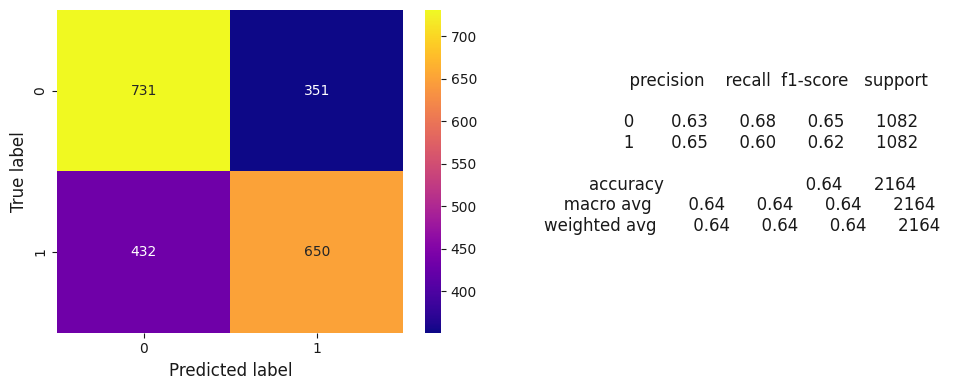

In [35]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(random_state=seed, verbose=0)

catboost.fit(X_train, y_train)

eval_model(catboost)

In [36]:
catboost_gscv = clone(catboost)

# param_grid = {
#     "learning_rate": [0.1, 0.05, 0.01],
#     "n_estimators": [100, 500, 1000],
#     "depth": [3, 5, 7],
#     "l2_leaf_reg": [0.0, 0.1, 0.5],
#     "colsample_bylevel": [0.5, 0.7, 0.9],
#     "subsample": [0.5, 0.7, 0.9],
#     "class_weights" : [class_weights]
# }
# # "roc_auc"
# grid_search = GridSearchCV(catboost_gscv, param_grid, scoring="roc_auc", n_jobs=-1)
# grid_search.fit(X_train, y_train)

# grid_search.best_params_

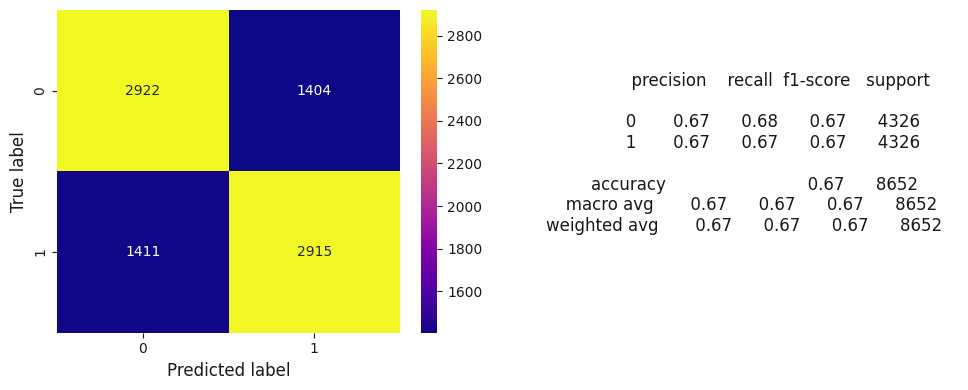

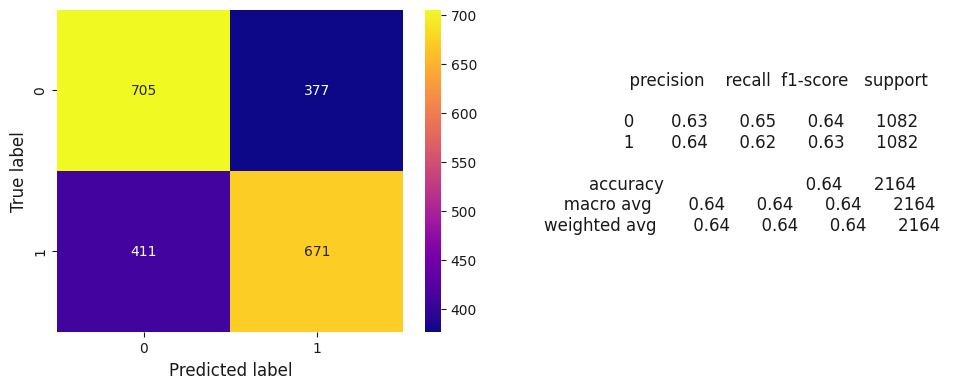

In [37]:
params = {
    "class_weights": [0.95, 1.0],
    "colsample_bylevel": 0.5,
    "depth": 5,
    "l2_leaf_reg": 0.1,
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "subsample": 0.7
    }

catboost_gscv.set_params(**params)
catboost_gscv.fit(X_train, y_train)

eval_model(catboost_gscv)

## Deep Neural Network

In [38]:
def analyze_model(_history, _model, _test_data=X_test, y_true=y_test):
    fig, axes = plt.subplots(2, 2, figsize=(10,8))

    # Generate predictions on the test data
    y_pred = _model.predict(_test_data)

    if y_pred.shape[1] == 1:
        y_pred = list((y_pred > 0.5).astype(int))
    else:
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_true, axis=1)

    # Print model metrics report
    metrics = classification_report(y_true, y_pred)
    ax=axes[1][1]
    ax.axis("off")
    ax.text(0.5, 0.25, metrics, size=12, ha="center", transform=ax.transAxes)

    # Generate a confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix
    ax=axes[1][0]
    sns.heatmap(cm, annot=True, fmt="d", cmap="plasma", ax=ax)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")

    # Plot the training and validation accuracy
    ax = axes[0][0]

    ax.plot(_history.history["accuracy"])
    ax.plot(_history.history["val_accuracy"])
    ax.set_title("Model Accuracy")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")
    ax.legend(["Train", "Val"])

    # Plot the training and validation loss
    ax = axes[0][1]
    ax.plot(_history.history["loss"])
    ax.plot(_history.history["val_loss"])
    ax.set_title("Model Loss")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    ax.legend(["Train", "Val"])

    fig.tight_layout()

In [39]:
# from keras import Sequential
# from keras.layers import Dense, Dropout, BatchNormalization, Dropout, Bidirectional
# from keras.callbacks import EarlyStopping
# from keras.optimizers import Adam
# from keras.regularizers import l1,l2

# model = Sequential([
#     Dense(64, "relu", input_dim=X_train.shape[1]),
#     BatchNormalization(),
#     Dropout(0.2),
#     Dense(32, "relu", kernel_regularizer=l2(0.01)),
#     Dropout(0.2),
#     Dense(32, "relu", kernel_regularizer=l2(0.01)),
#     Dense(16, "relu"),
#     Dense(1, "sigmoid")
# ])

# model.compile(Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy", "Recall"])

# history = model.fit(
#     X_train.values, y_train.values, 
#     batch_size=32, 
#     epochs=50, 
#     validation_data=(X_test.values, y_test.values),
#     callbacks=[
#         EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)],
#     class_weight={0:.95, 1:1.0}
# )

# model.save("RNN_info/RNN.h5")
# with open("RNN_info/RNN_history.pickle", "wb") as file:
#     pickle.dump(history, file)


Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-04-19 11:24:58         3912
metadata.json                                  2023-04-19 11:24:58           64
variables.h5                                   2023-04-19 11:24:58        93944
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
......recal

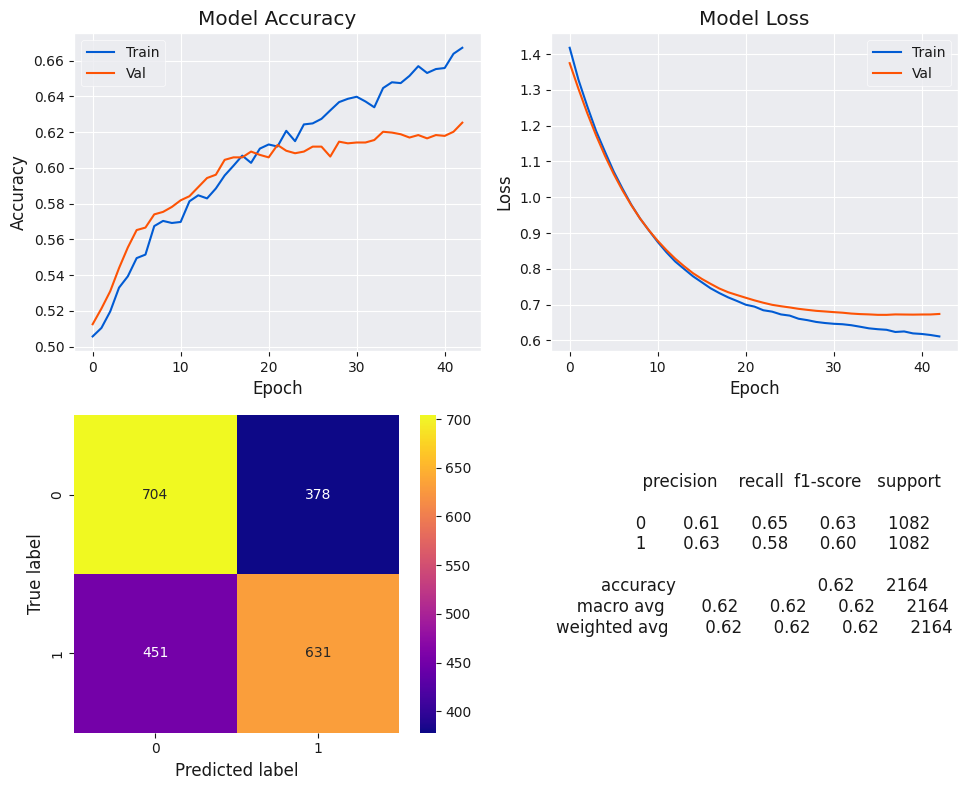

In [46]:
from keras.models import load_model

# load the saved model
model = load_model("RNN_info/RNN.h5")
with open("RNN_info/RNN_history.pickle", "rb") as file:
    history = pickle.load(file)

analyze_model(history, model)

# Visualizations

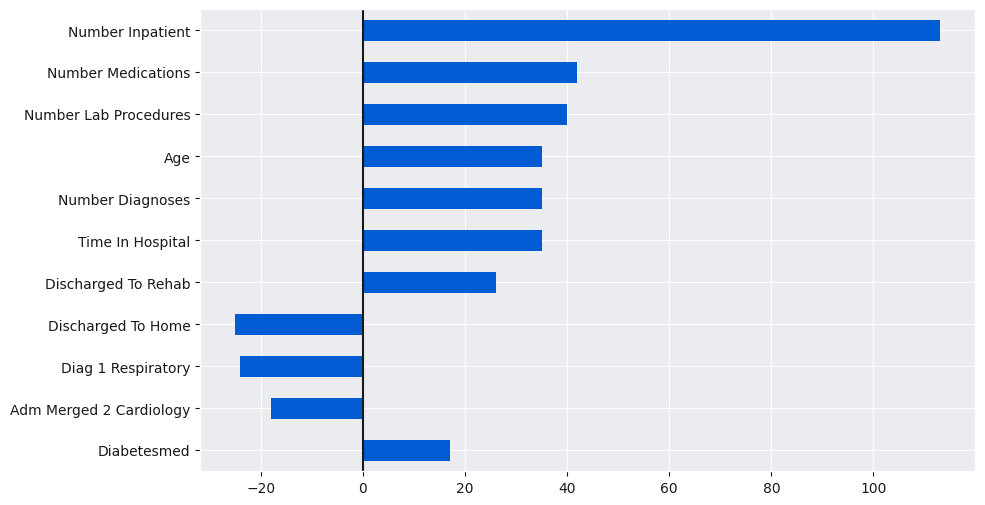

In [41]:
replacements = (
    ("discharge_disposition_id_3", "Discharged to SNF"),
    ("discharge_disposition_id_1", "Discharged to Home"),
    ("discharge_disposition_id_22", "Discharged to Rehab"),
    ("num_", "number_")
)

def prep_label(string):
    for to, repl in replacements:
        string = string.replace(to, repl)
    
    return string.replace("_", " ").title()


# importances = pd.Series(catboost_gscv.get_feature_importance(type="PredictionValuesChange"), index=X_train.columns)
importances = pd.Series(lgbm_gscv.feature_importances_, X_train.columns)

_X = pd.concat([X_train, X_test])
_y = pd.concat([y_train, y_test])

important_feats = importances.sort_values(ascending=True)[-11:]

fig, ax = plt.subplots(figsize=(10,6))
ax.vlines([0], 11, -1, colors="#191919")
(important_feats * _X.corrwith(y)[important_feats.index].apply(lambda x: -1 if x < 0 else 1)).plot(kind="barh", ax=ax)
labels = [prep_label(label) for label in important_feats.index]
ax.set_yticklabels(labels)

fig.savefig("Presentation/Images/lgbm_importances.png", dpi=300)

68/68 [==============================] - 0s 980us/step


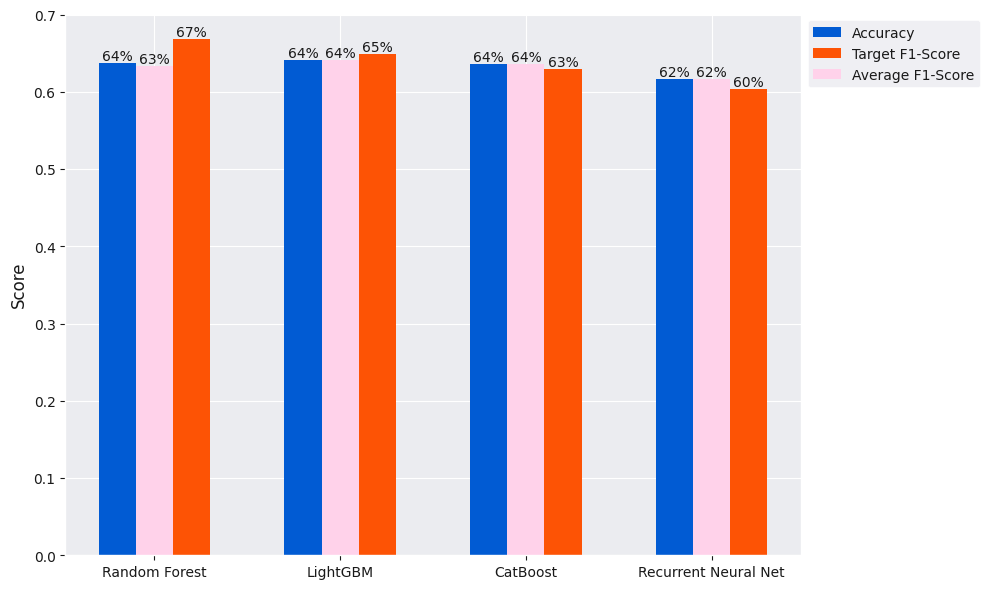

In [42]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

models = [rand_forest_gscv, lgbm_gscv, catboost_gscv, model]
model_names = ["Random Forest", "LightGBM", "CatBoost", "Recurrent Neural Net"]
accs, target_f1s, avg_f1s = [], [], []


for _model in models:
    preds = _model.predict(X_test)
    preds = list((preds > 0.5).astype(int))

    precision, recall, f1_score, support  = precision_recall_fscore_support(y_test, preds,)
    acc = accuracy_score(y_test, preds)
    target_f1 = f1_score[1]
    avg_f1 = f1_score.mean()

    accs.append(acc)
    target_f1s.append(target_f1)
    avg_f1s.append(avg_f1)

metrics = ["Accuracy", "Target F1-Score", "Average F1-Score"]
x_pos = np.arange(len(model_names))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x_pos - width, accs, width, label="Accuracy")
ax.bar(x_pos + width, target_f1s, width, label="Target F1-Score")
ax.bar(x_pos, avg_f1s, width, label="Average F1-Score")

ax.set_xticks(x_pos)
ax.set_xticklabels(model_names)
ax.set_ylabel("Score")
ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

for i, v in enumerate(accs):
    ax.annotate(str(round(v*100)) + "%", xy=(i-width, v), ha="center", va="bottom")
for i, v in enumerate(target_f1s):
    ax.annotate(str(round(v*100)) + "%", xy=(i+width, v), ha="center", va="bottom")
for i, v in enumerate(avg_f1s):
    ax.annotate(str(round(v*100)) + "%", xy=(i, v), ha="center", va="bottom")


fig.tight_layout()

fig.savefig("Presentation/Images/ModelComparison.png", dpi=300)

In [55]:
_X = pd.concat([X_train, X_test]).median()
discharge_ids = _X.index[_X.index.str.contains("discharge_disposition_id")]
_X.loc[discharge_ids] = 0

preds = pd.Series(dtype=float)

for id in discharge_ids:
    x = _X.copy()
    x.loc[id] = 1
    x = np.reshape(x.values, (1, -1))

    pred = lgbm_gscv.predict_proba(x)

    id = id.split("_")[-1]
    name = discharge_type_map.loc[id].description
    preds.loc[name] = pred[0][1]

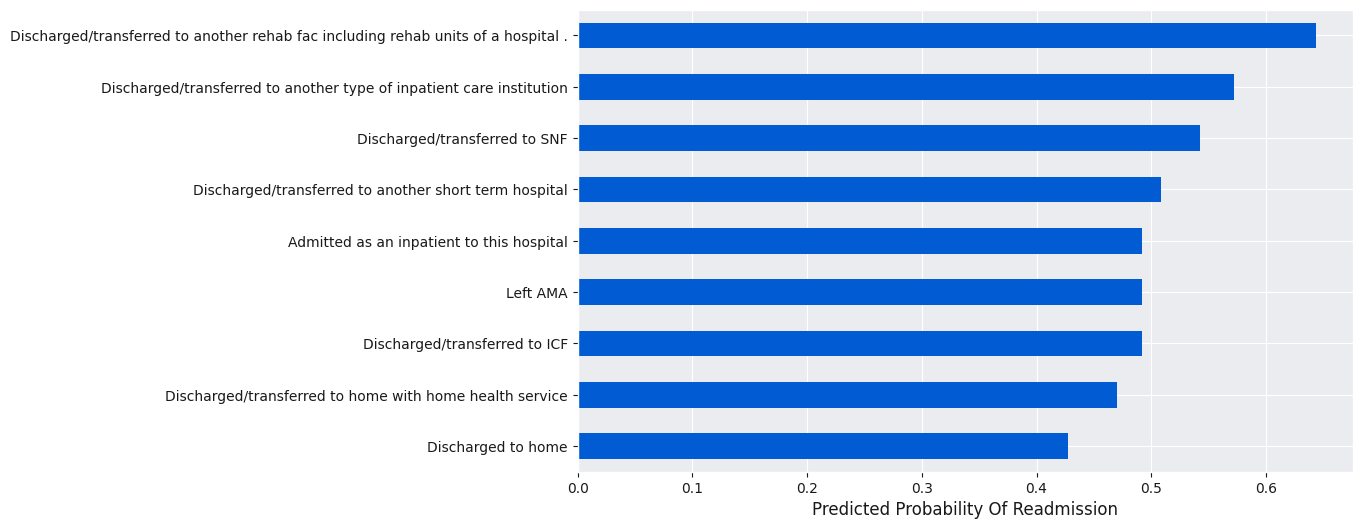

In [56]:
preds.sort_values(inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))
preds.plot(kind="barh", ax=ax)
ax.set_xlabel("predicted probability of readmission".title())
fig.savefig("Presentation/Images/DischargeTypes.png", dpi=300)

In [45]:
import os

# Alert me when notebook is finished so that I can multitask
total_time = (time.time() - start_time) / 60 

def alert(title="title", text="text"):
    os.system("""
              osascript -e "display alert "{}" message "{}""
              """.format(title, text))
    
alert("Notebook Completed!", f"Completed in {total_time} minutes.")

14:22: execution error: The variable Notebook is not defined. (-2753)
